### README
This code is used to plot the weather regimes, and also to remap the (random) clustering order from `01a_WR_clustering.py` to a standardised order, used in the rest of the scripts. This has to be manually adapted below via CLUSTER_REMAPPING to match the order given by CLUSTER_NAMES in `config.py`

Author: Bram van Duinen (bramvduinen@gmail.com)

### 1. Preliminaries

In [1]:
import ast
import os

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import xarray as xr
from config import PATH_CLUSTERS, VERSION, CLUSTER_NAMES

In [2]:
centroids_real_space_raw = xr.open_dataarray(os.path.join(PATH_CLUSTERS, VERSION,
                                                      "centroids_unordered.nc"))
lons = centroids_real_space_raw.lon.to_numpy()
lats = centroids_real_space_raw.lat.to_numpy()
df_cluster_raw = pd.read_csv(os.path.join(PATH_CLUSTERS, VERSION, "df_clusters_full_unordered.csv"))
df_cluster_raw["time"] = pd.to_datetime(df_cluster_raw["time"])

### 2. Defining Functions

In [3]:
alphabet = ['(a)', '(b)', '(c)', '(d)']

def plot_clusters(df, centroids_real_space, z500_clim, lons, lats, cluster_names, ordered=True):
    """Plot zg500 clusters on a map.
    """
    n_clusters = centroids_real_space.shape[0]
    levels_z500 = np.arange(5000, 6000, 100)

    fig, axs = plt.subplots(2, 2, figsize=(9, 6),
                            subplot_kw={"projection": ccrs.LambertConformal(central_longitude=-30, central_latitude=50)}, dpi=300)

    axs = axs.flatten()
    if ordered:
        titles = cluster_names
        titles[3] = "Atlantic Ridge"
    else:
        titles = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"]

    # only calc percentages based the first 4 clusters, i.e. ignore no-regime
    percentages = df.query("Bayes_cluster <= 3")['Bayes_cluster'].value_counts(normalize=True, sort=False).sort_index().to_list()
    
    for i, ax in enumerate(axs):
        if i < n_clusters:
            ax.set_extent([-90, 30, 20, 77.8], crs=ccrs.PlateCarree())
            
            # Does boundary with the correct shape
            theta = np.linspace(0, 2*np.pi, 100)
            center, radius = [0.5, 1.281944444], 0.314789
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T * radius + center
            temp = []
            for j in range(len(verts)):
                if verts[j][1]<1 :
                    temp.append([verts[j][0],1-(1-verts[j][1])*2.1])
            boundary = [[.36,1]]
            boundary.extend(temp[::-1])
            boundary.extend([[.64,1],[1,.275]])
            theta = np.linspace(0, 2*np.pi, 100)
            center, radius = [0.5, 1.281944444], 1.281944444
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T * radius + center
            temp = []
            for j in range(len(verts)):
                if verts[j][1]<0.275 and verts[j][0]<1 and verts[j][0]>0:
                    temp.append([verts[j][0],verts[j][1]*2.7])
            boundary.extend(temp)
            boundary.extend([[0,.275]])
            boundary = mpath.Path(boundary)
            ax.set_boundary(boundary, transform=ax.transAxes)

            fill = ax.contourf(
                lons,
                lats,
                centroids_real_space[i, :, :].squeeze(),
                levels=np.linspace(-200, 200, 21),
                cmap=plt.cm.RdBu_r,
                extend="both",
                transform=ccrs.PlateCarree())

            CS = ax.contour(
                lons,
                lats,
                centroids_real_space[i, :, :].squeeze() + z500_clim,
                levels=levels_z500,
                colors=".25",
                linewidths=1,
                transform=ccrs.PlateCarree())
            ax.clabel(CS, inline=True, fontsize=10)
            
            ax.coastlines(resolution="110m")
            ax.set_title(f"{alphabet[i]} {titles[i]}")

            ax.text(35,70, f"{round(100*percentages[i])}%",fontsize=12, transform=ccrs.Geodetic())

    ypos = .05
    xpos = 0.165
    xlen = 0.7
    ylen = 0.025
    cbar_ax = fig.add_axes([xpos, ypos, xlen, ylen])
    cb = fig.colorbar(fill, cax=cbar_ax, orientation="horizontal", label="500 hPa height anomaly [m]", extend="both", ticks=np.arange(-200, 250, 50))

    plt.show()

In [4]:
def remap_lists(df, df_raw, column, mapping):
    column_arr = np.array(df_raw[column].apply(ast.literal_eval).tolist(), dtype = float)
    column_reshape = column_arr[:, list(mapping.values())[:4]]
    df[column] = column_reshape.tolist()
    return df

### 3. Plotting

In [5]:
z500 = xr.open_dataarray("/usr/people/duinen/MSc-thesis/Data/clim_zg500_v1.nc")
z500 = z500.where(
        (z500["lon"] < 30) &
        (z500["lat"] > 20) &
        (z500["lat"] < 80) &
        ((z500["dayofyear"] > 304) | (z500["dayofyear"] < 91)),
)
        
z500 = z500.sel(lon=slice(None, 30), lat=slice(20, 80))
z500_coarse = z500.coarsen(lon = 3).mean().coarsen(lat = 3, boundary = "trim").mean()
z500_clim = z500_coarse.mean(dim = "dayofyear", skipna = True)

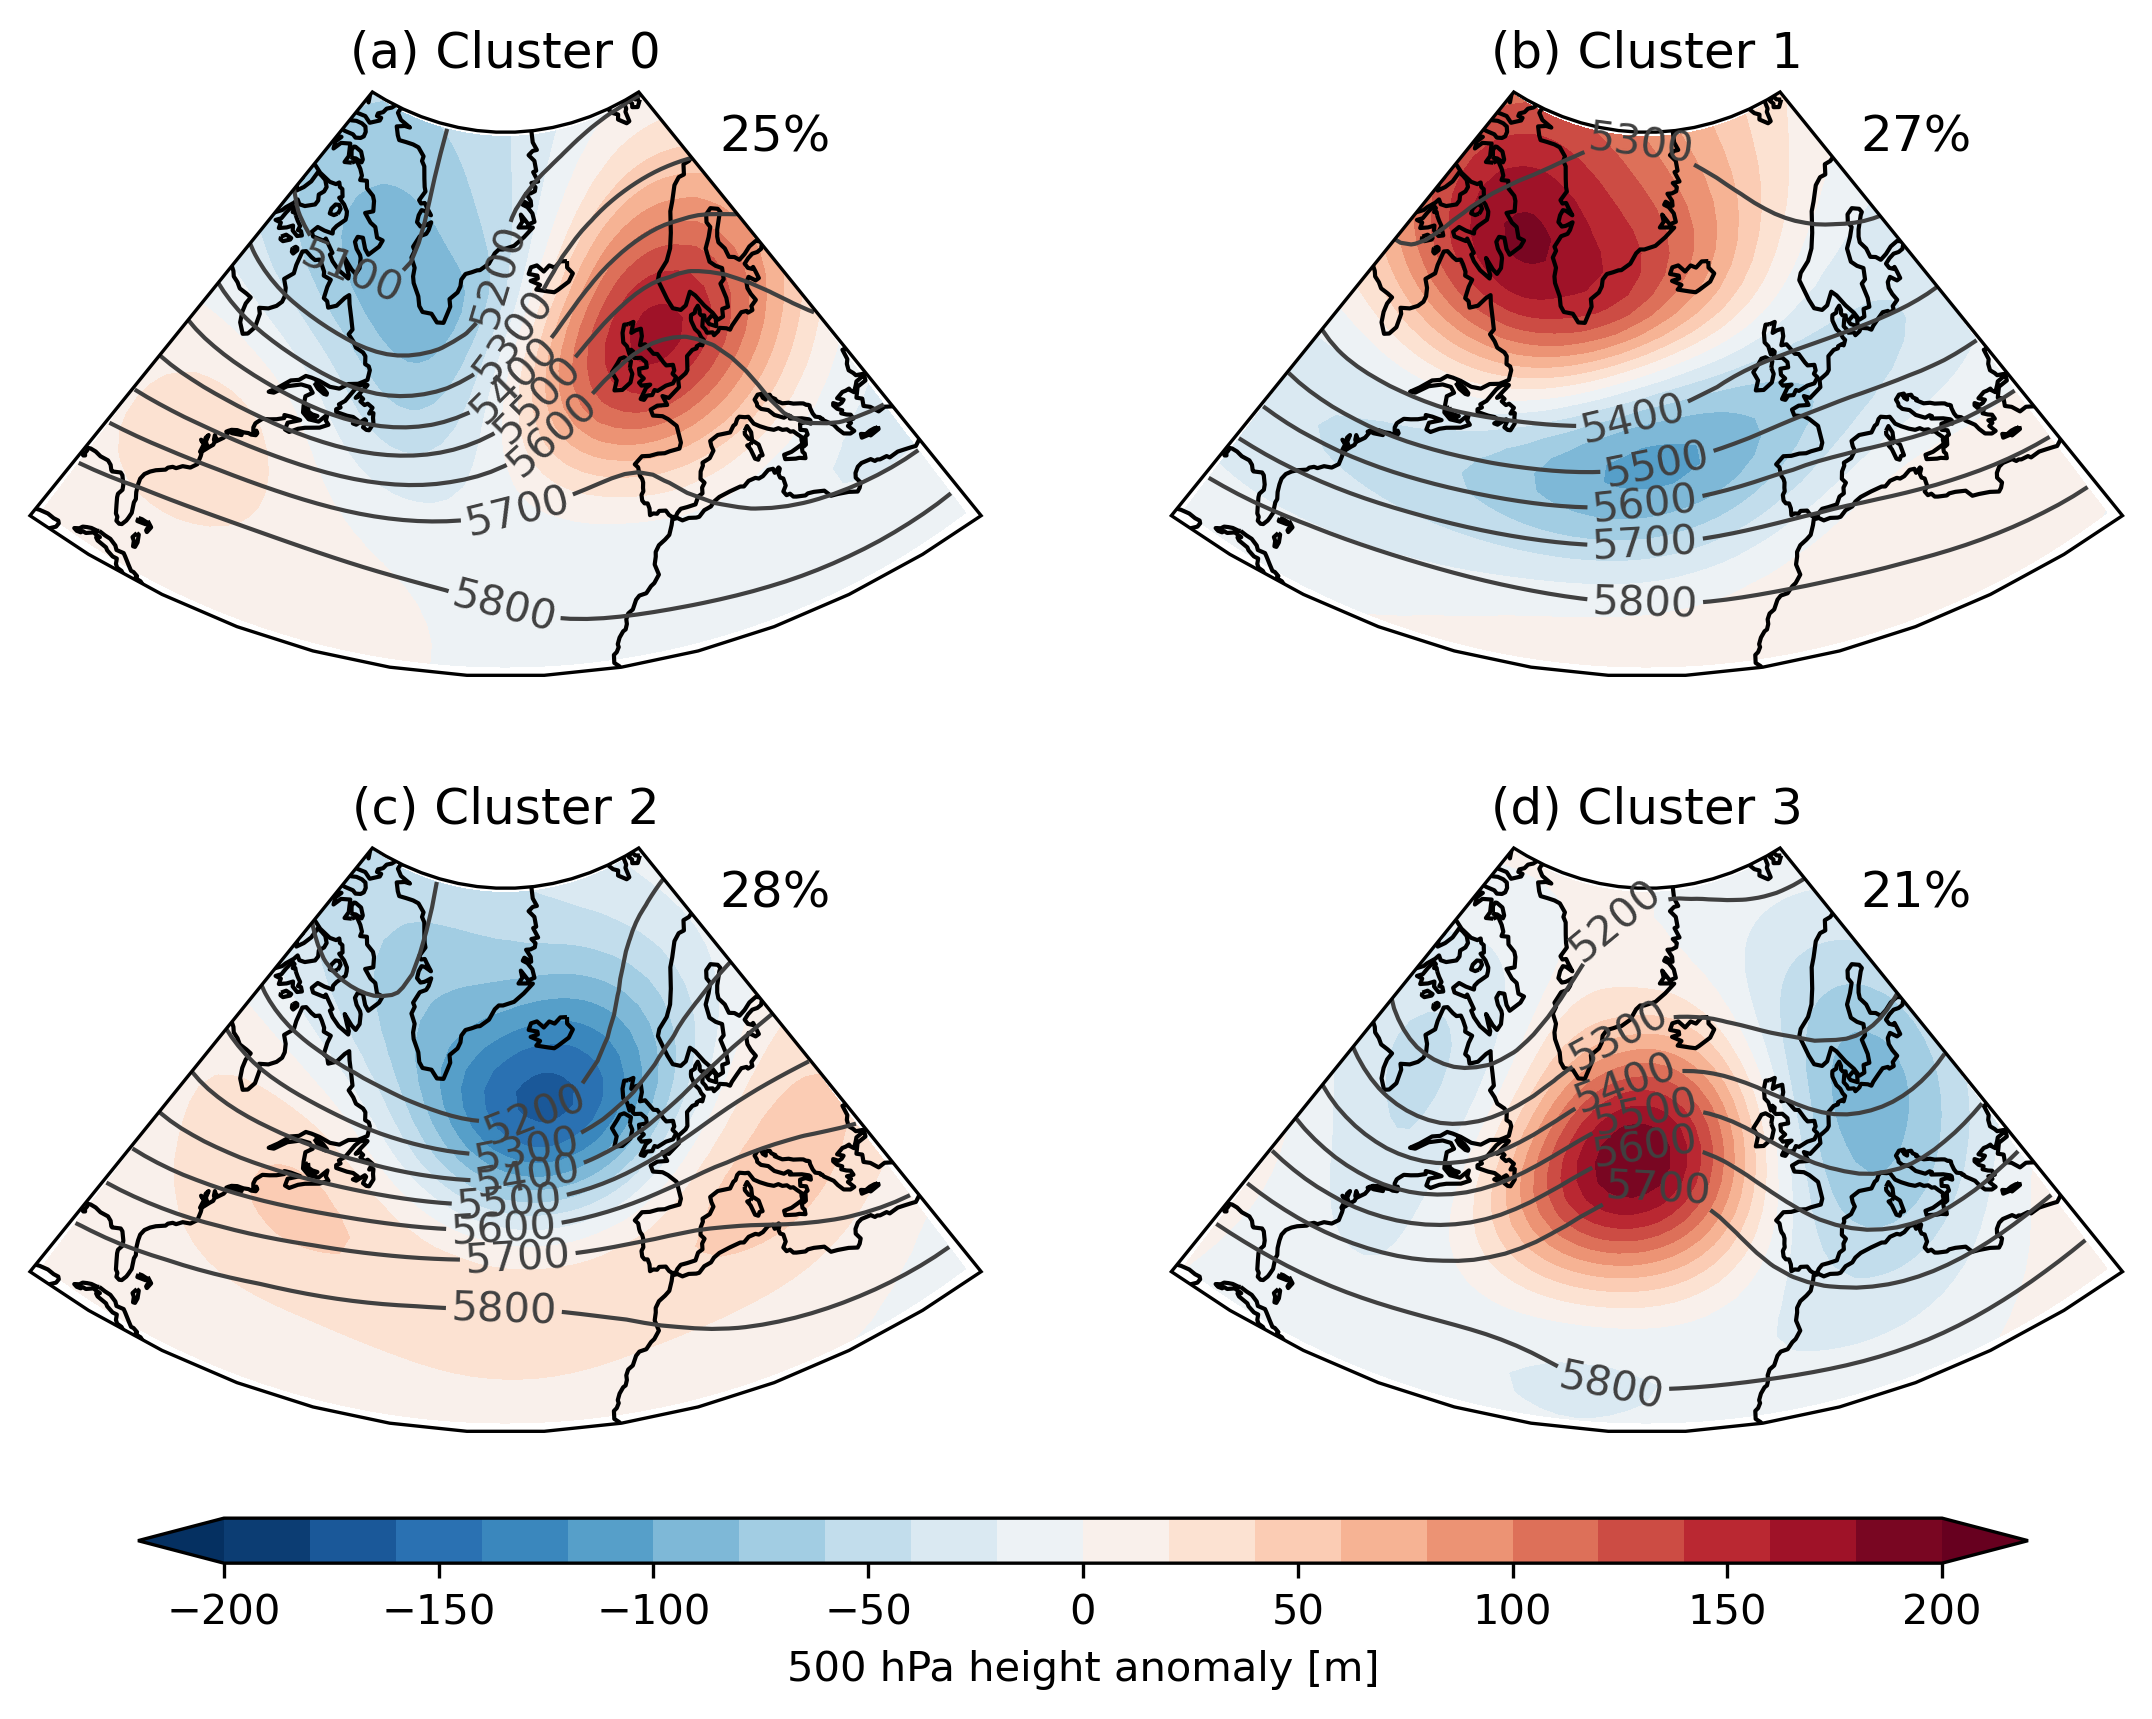

In [6]:
plot_clusters(df_cluster_raw, centroids_real_space_raw, z500_clim, lons, lats, CLUSTER_NAMES, ordered = False)

In [7]:
# cluster 0 becomes cluster 2, cluster 1 stays cluster 1 etc.
CLUSTER_REMAPPING = {0: 2, 1: 1, 2: 0, 3: 3, 4: 4} # make sure to change after new clustering run!
df_cluster = df_cluster_raw[['time', 'run']].copy()
df_cluster['Bayes_cluster'] = df_cluster_raw['Bayes_cluster'].map(CLUSTER_REMAPPING)
df_cluster['Bayes_cluster_raw'] = df_cluster_raw['Bayes_cluster_raw'].map(CLUSTER_REMAPPING)
df_cluster['raw_cluster_id'] = df_cluster_raw['cluster_id'].map(CLUSTER_REMAPPING)

remap_lists(df_cluster, df_cluster_raw, "prior", CLUSTER_REMAPPING)
remap_lists(df_cluster,  df_cluster_raw, "likelihood", CLUSTER_REMAPPING)
remap_lists(df_cluster,  df_cluster_raw, "posterior", CLUSTER_REMAPPING)
remap_lists(df_cluster,  df_cluster_raw, "wri", CLUSTER_REMAPPING)
centroids_real_space = centroids_real_space_raw[list(CLUSTER_REMAPPING.values())[:4], :, :]

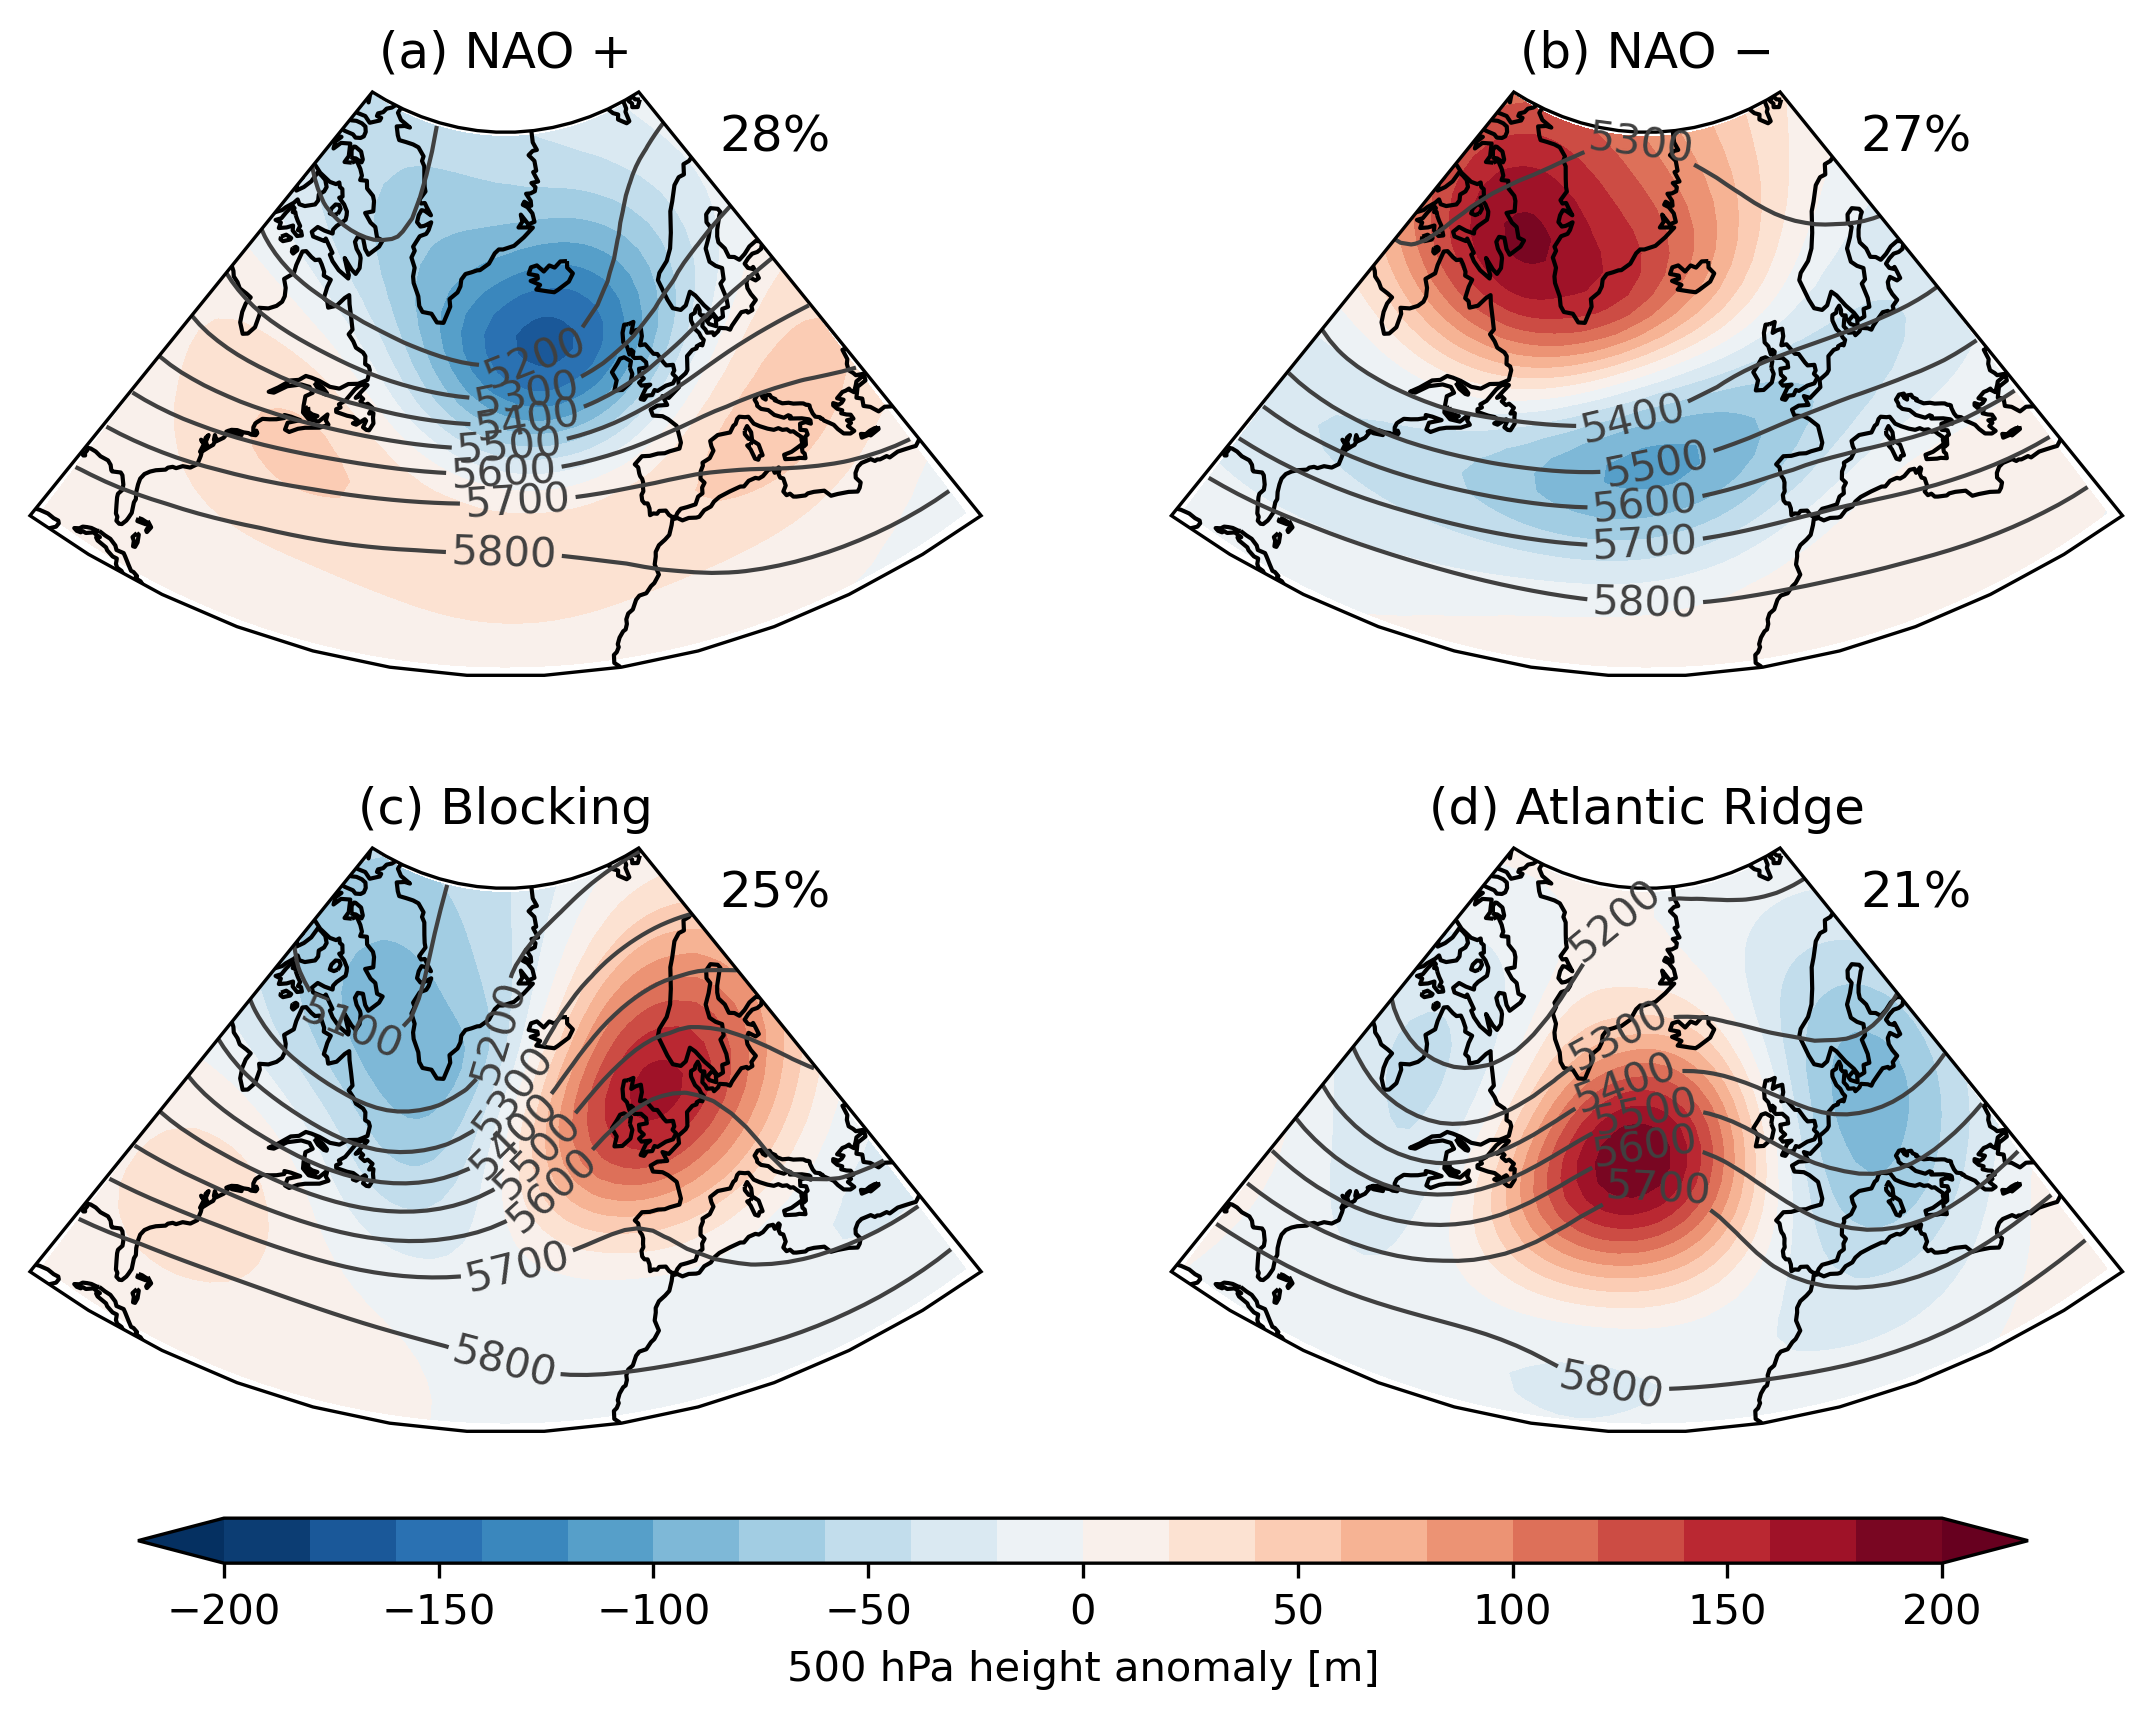

In [8]:
plot_clusters(df_cluster, centroids_real_space, z500_clim, lons, lats, CLUSTER_NAMES, ordered = True)

In [11]:
# save reordered data with standardised order, for usage in further scripts
df_cluster.to_csv(os.path.join(PATH_CLUSTERS, VERSION, "df_clusters_full_ordered.csv"), index = False)
centroids_real_space.to_netcdf(os.path.join(PATH_CLUSTERS, VERSION, "centroids_ordered.nc"))

KeyboardInterrupt: 